# Calculate weights

### Add paths to run locally or off NIRD

In [1]:
import sys
# Add common resources folder to path
sys.path.append("/mnt/mcc-ns9600k/jonahks/git_repos/netcdf_analysis/Common/")
sys.path.append("/mnt/mcc-ns9600k/jonahks/git_repos/netcdf_analysis/")
sys.path.append("/mnt/mcc-ns9600k/jonahks/git_repos/netcdf_analysis/hdf_caliop/")
sys.path.append("/home/jonahks/git_repos/netcdf_analysis/")
sys.path.append("/home/jonahks/git_repos/netcdf_analysis/Common/")

from imports import (
    pd, np, xr, mpl, plt, sns, os, 
    datetime, sys, crt, gridspec,
    ccrs, metrics, Iterable
    )

from functions import (
    masked_average, add_weights, sp_map,
    season_mean, get_dpm, leap_year, share_ylims,
    to_png, mute_ax
    )

from classes import SatComp_Metric, CT_SLF_Metric
from collections import deque
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Check running location and adjust working directory appropriately.

In [2]:
host = os.uname()[1]
if 'jupyter' in host.split('-'): # Check if running on NIRD through the Jupyter Hub
    print('Running through MC2 Jupyter Hub')
    model_dir = '/mnt/mcc-ns9600k/jonahks/'
    os.chdir(model_dir)

else:  # Assume that we're running on a local machine and mounting NIRD
    print('Running on %s, attempting to mount ns9600k/jonahks/ from NIRD' % str(host))
    os.system('fusermount -zu ~/drivemount/')  # unmount first
    os.system('sshfs jonahks@login.nird.sigma2.no:"p/jonahks/" ~/drivemount/')    # Calling mountnird from .bashrc doesn't work
    os.chdir('/home/jonahks/drivemount/')
    save_dir = '~/DATAOUT/'
    save_to = os.path.expanduser(save_dir)

output_dir = 'figures/'
case_dir = 'satcomp/'   # inconsistent label compared to jupy_test
conv_dir ='convectivephase/'

# Check that each important directory can be accessed:    
access_paths = os.path.exists(output_dir) and os.path.exists(case_dir) and os.path.exists(conv_dir)
print('Can access all directory paths:', access_paths)

Running through MC2 Jupyter Hub
Can access all directory paths: True


In [3]:
pwd

'/mnt/mcc-ns9600k/jonahks'

In [4]:
netcdf_dir = '/mnt/mcc-ns9600k/jonahks/caliop_slf_weight/netcdf_processed/'
os.chdir(netcdf_dir)

In [6]:
files = os.listdir()

In [7]:
files[0]

'CAL_LID_L3_Cloud_Occurrence-Standard-V1-00.2010-04A.nc'

In [8]:
ds = xr.open_dataset(files[0])

In [9]:
ds

<xarray.Dataset>
Dimensions:                            (alt: 344, lat: 85, lon: 144)
Coordinates:
  * lat                                (lat) float32 -84.0 -82.0 ... 82.0 84.0
  * lon                                (lon) float32 -178.75 -176.25 ... 178.75
  * alt                                (alt) float32 -0.3800481 ... 20.166965
Data variables:
    Days_Of_Month_Observed             (lat, lon) float64 ...
    N_Days_Observed                    (lat, lon) int64 ...
    Pressure_Mean                      (lat, lon, alt) float32 ...
    Pressure_Standard_Deviation        (lat, lon, alt) float32 ...
    Temperature_Mean                   (lat, lon, alt) float32 ...
    Temperature_Standard_Deviation     (lat, lon, alt) float32 ...
    Cloud_Free_Samples                 (lat, lon, alt) float64 ...
    Cloud_Samples                      (lat, lon, alt) float64 ...
    Cloud_Rejected_Samples             (lat, lon, alt) float64 ...
    Cloud_Accepted_Samples             (lat, lon, alt) float64 ...
    Unknown_Cloud_Transparent_Samples  (lat, lon, alt) float64 ...
    Unknown_Cloud_Opaque_Samples       (lat, lon, alt) float64 ...
    Water_Cloud_Transparent_Samples    (lat, lon, alt) float64 ...
    Water_Cloud_Opaque_Samples         (lat, lon, alt) float64 ...
    Ice_Cloud_Transparent_Samples      (lat, lon, alt) float64 ...
    Ice_Cloud_Opaque_Samples           (lat, lon, alt) float64 ...

## Create cloud fraction variable

Defined here:  
https://www-calipso.larc.nasa.gov/resources/calipso_users_guide/qs/cal_lid_l3_cloud_occurrence_v1-00.php

In [54]:
all_samples = ds['Cloud_Accepted_Samples'] + ds['Cloud_Rejected_Samples'] + ds['Cloud_Free_Samples']
ds['Cloud_Fraction'] = ds['Cloud_Accepted_Samples'] / all_samples

## Bin by temperature

The weights will depend on the isotherm width. 2C is consistent with the model variables.

In [59]:
isotherm = -40
tolerance = 1

Get gridcells within the bin.

In [60]:
bool_arrayA = ds['Temperature_Mean'] > (isotherm - tolerance)
bool_arrayB = ds['Temperature_Mean'] < (isotherm + tolerance)
bool_array = np.bitwise_and(bool_arrayA ,bool_arrayB)

#### Looks right

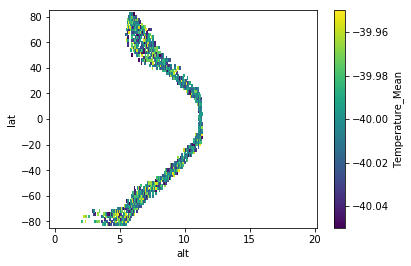

In [50]:
plt.figure()
ds['Temperature_Mean'].where(bool_array).mean('lon').plot()

### Weighting by isotherm will focus on the midlatitudes

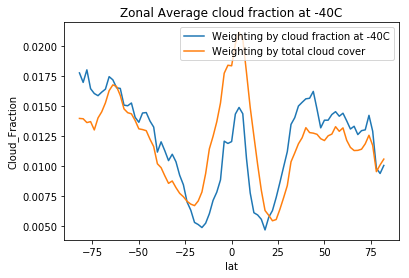

In [83]:
plt.figure()
cloud40C = ds['Cloud_Fraction'].where(bool_array).mean(['lon','alt'])
cloud40C_norm = cloud40C / cloud40C.sum('lat')
np.testing.assert_allclose(cloud40C_norm.sum(),1)
# np.testing.assert_allclose(weights.groupby('time.season').sum().values, np.ones(4))
cloud40C_norm.plot(label='Weighting by cloud fraction at -40C')
allcloud = ds['Cloud_Fraction'].mean(['lon','alt'])
allcloud_norm = allcloud / allcloud.sum('lat')
np.testing.assert_allclose(allcloud_norm.sum(),1)

allcloud_norm.plot(label='Weighting by total cloud cover')
plt.title('Zonal Average cloud fraction at -40C')
plt.legend()

In [101]:
def calc_isoweights(ds,T,Ttol):
    '''
    Calculate the average cloud fraction over a temperature bin.
    
    ds: processed CALIOP level data
    T: Temperature bin center
    Ttol: Temperature bin halfwidth
    '''
    
    bool_arrayA = ds['Temperature_Mean'] > (T - Ttol) # lower bound
    bool_arrayB = ds['Temperature_Mean'] < (T + Ttol) # upper bound
    bool_array = np.bitwise_and(bool_arrayA ,bool_arrayB) # within bounds
    
    cloud_frac = ds['Cloud_Fraction'].where(bool_array).mean(['alt']) # average over height
    
    weight = cloud_frac / cloud_frac.sum(['lat','lon'])
    np.testing.assert_allclose(weight.sum(['lat','lon']),1)
    
    return weight

In [91]:
testweight = calc_isoweights(ds,-40,1)

In [98]:
np.linspace(-40,0,9)

array([-40., -35., -30., -25., -20., -15., -10.,  -5.,   0.])

### Generally looks good, but why the huge weight on SO clouds for 0C and -10C.

So this is saying that most clouds at -10C are in the southern ocean? I guess that makes sense.

Text(0.5,0,'Latitude')

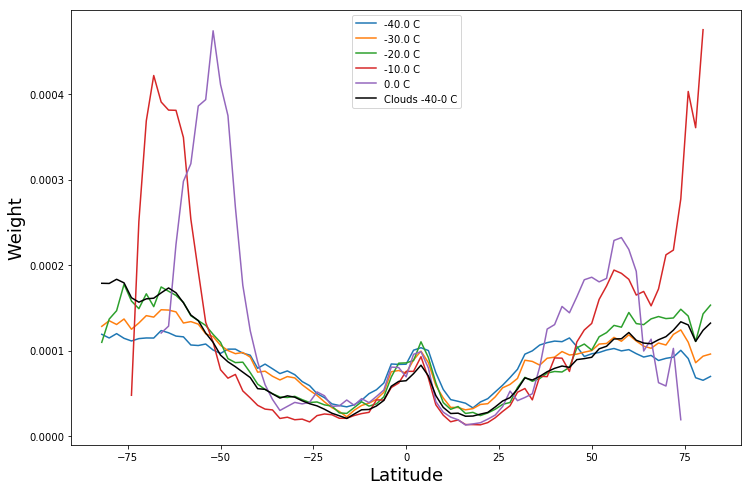

In [127]:
fig = plt.figure(figsize=[12,8])
for iso in np.linspace(-40,0,5):
    label = "%s C" % iso
    _weight = calc_isoweights(ds,iso,1)
    
    _weight.mean('lon').plot(label=label)

all_weight = calc_isoweights(ds,-20,20) # -
    
all_weight.mean('lon').plot(label='Clouds -40-0 C',color='black')
    
plt.legend()
plt.ylabel('Weight',fontsize=18)
plt.xlabel('Latitude',fontsize=18)

In [132]:
pwd

'/mnt/mcc-ns9600k/jonahks/caliop_slf_weight/netcdf_processed'

In [133]:
ls /mnt/mcc-ns9600k/jonahks/

AMWG_diag/                 Diagnostics_Output/  NoresmDiagnostics/
caliop_olimpia/            feedbacks_soden/     NorESM_validation/
caliop_olimpia_new/        figures/             nudging_dev/
caliop_slfs/               git_repos/           olimpia_cosp/
caliop_slf_weight/         GOCCP_data/          resolution_stuff/
CAM6_satcomp_wbf_1_inp_1/  inp_obs/             satcomp/
CERES_EBAF/                inp_validation/      satcomp_+4K/
conspiracy_stuff/          mnth15runs/          slf_validation/
convectivephase/           MODIS_COSP/


In [131]:
ls ../../..

AMWG_diag/                 Diagnostics_Output/  NoresmDiagnostics/
caliop_olimpia/            feedbacks_soden/     NorESM_validation/
caliop_olimpia_new/        figures/             nudging_dev/
caliop_slfs/               git_repos/           olimpia_cosp/
caliop_slf_weight/         GOCCP_data/          resolution_stuff/
CAM6_satcomp_wbf_1_inp_1/  inp_obs/             satcomp/
CERES_EBAF/                inp_validation/      satcomp_+4K/
conspiracy_stuff/          mnth15runs/          slf_validation/
convectivephase/           MODIS_COSP/


In [134]:
to_png(fig,'mixedphase_weighting')

Text(0.5,0,'Latitude')

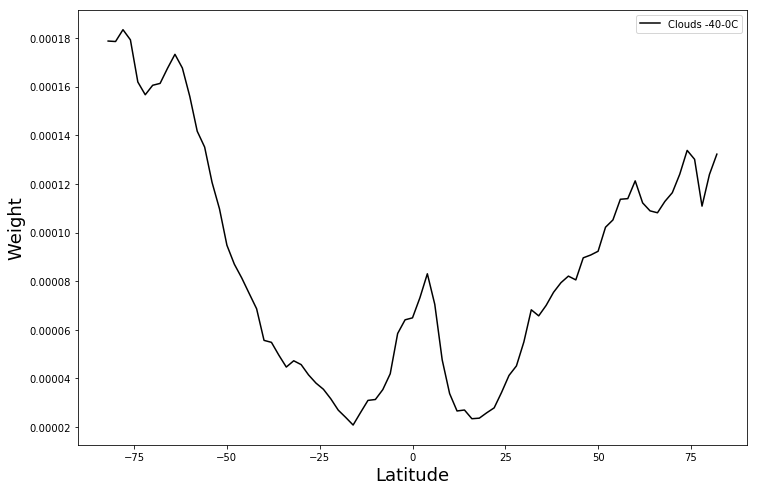

In [118]:
plt.figure(figsize=(12,8))
_weight = calc_isoweights(ds,-20,20)
    
_weight.mean('lon').plot(label='Clouds -40-0C',color='black')

plt.legend()
plt.ylabel('Weight',fontsize=18)
plt.xlabel('Latitude',fontsize=18)

In [63]:
plt.figure()
ds['Cloud_Fraction'].where(bool_array).mean(['lon',].sum('alt')).plot()

AttributeError: 'list' object has no attribute 'sum'

<Figure size 432x288 with 0 Axes>

In [14]:
bool_array = np.where((ds['Temperature_Mean'] > (isotherm - tolerance)) and (ds['Temperature_Mean'] < (isotherm + tolerance)))

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [13]:
bool_array

<xarray.DataArray 'Temperature_Mean' (lat: 85, lon: 144, alt: 344)>
array([[[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]],

       [[False, False, False, ...,  True,  True,  True],
        [False, False, False, ...,  True,  True,  True],
        [False, False, False, ...,  True,  True,  True],
        ...,
        [False, False, False, ...,  True,  True,  True],
        [False, False, False, ...,  True,  True,  True],
        [False, False, False, ...,  True,  True,  True]],

       [[False, False, False, ...,  True,  True,  True],
        [False, False, False, ...,  True,  True,  True],
        [False, False, False, ...,  True,  True,  True],
        ...,
        [False, False, False, ...,  True,  True,  True],
        [False, False, False, ...,  True,  True,  True],
        [False, False, False, ...,  True,  True,  True]],

       ...,

       [[False, False, False, ...,  True,  True,  True],
        [False, False, False, ...,  True,  True,  True],
        [False, False, False, ...,  True,  True,  True],
        ...,
        [False, False, False, ...,  True,  True,  True],
        [False, False, False, ...,  True,  True,  True],
        [False, False, False, ...,  True,  True,  True]],

       [[False, False, False, ...,  True,  True,  True],
        [False, False, False, ...,  True,  True,  True],
        [False, False, False, ...,  True,  True,  True],
        ...,
        [False, False, False, ...,  True,  True,  True],
        [False, False, False, ...,  True,  True,  True],
        [False, False, False, ...,  True,  True,  True]],

       [[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]]])
Coordinates:
  * lat      (lat) float32 -84.0 -82.0 -80.0 -78.0 -76.0 ... 78.0 80.0 82.0 84.0
  * lon      (lon) float32 -178.75 -176.25 -173.75 ... 173.75 176.25 178.75
  * alt      (alt) float32 -0.3800481 -0.32014424 ... 20.107063 20.166965

In [ ]:
ds['Cloud_Accepted_Samples'].where(ds['Temperature_Mean'])

/opt/conda/lib/python3.7/site-packages/xarray/core/nanops.py:140: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


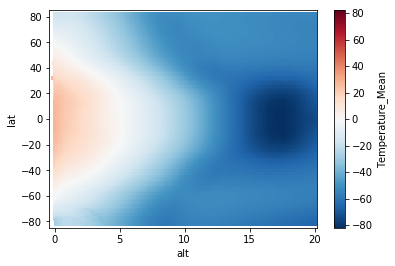

In [10]:
ds['Temperature_Mean'].mean('lon').plot()